In [7]:
import pandas as pd
from modalities.utils.profilers.profile_logs_analyzers import ProfileLogsAnalyzer
from pathlib import Path

In [8]:
log_dirs = {
    "FSDP2": Path("/raid/s3/opengptx/max_lue/repositories/modalities/tutorials/profiling/experiments/2025-04-28__21-55-30_890b7ede"), 
    # "compile": Path("/raid/s3/opengptx/max_lue/repositories/modalities/tests/training/benchmark/2025-04-25__01-13-08_ed5e5044")
}
results_dict = {}
for name, log_dir in log_dirs.items():
    results = ProfileLogsAnalyzer.load_profiling_logs(log_dir)
    df = ProfileLogsAnalyzer.to_pandas_df(results)
    df["total_step_time"] = df["forward_time"] + df["backward_time"] + df["step_time"]
    df.sort_values(by=["total_step_time"], inplace=True, ascending=True)
    df["error"] = df["error"].apply(lambda x: x[:20])
    results_dict[name] = df
    df["ac_ops_keys"] = df["ac_ops_keys"].apply(lambda x: " ".join(x))

In [9]:
def filter_df(df):
    df_filtered = df.groupby(by=["ac_ops_keys", "batch_size"]).first().reset_index()
    df_filtered = df_filtered[df_filtered["error"] == ""]
    return df_filtered

results_dict = {
    name: filter_df(df) for name, df in results_dict.items()
}

In [10]:
def combine_dfs(result_dict: dict[str, pd.DataFrame]) -> pd.DataFrame:
    combined_df = pd.concat(result_dict.values(), keys=result_dict.keys())
    combined_df.reset_index(level=0, inplace=True)
    combined_df.rename(columns={"level_0": "name"}, inplace=True)
    return combined_df

combined_df = combine_dfs(results_dict)
combined_df["lines"] = combined_df["name"]  + "_" + combined_df["ac_ops_keys"]
combined_df

,name,ac_ops_keys,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,lines
0,FSDP2,,1,4096,50304,1,1,8,dgx2,70597.919434,0.124337,0.980498,0.161218,,1.266053,FSDP2_
9,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,1,4096,50304,1,1,8,dgx2,20596.247559,0.172272,1.455008,0.153634,,1.780915,FSDP2_torch.ops._c10d_functional.reduce_scatte...
10,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,2,4096,50304,1,1,8,dgx2,25308.341309,0.116002,1.453387,0.131507,,1.700896,FSDP2_torch.ops._c10d_functional.reduce_scatte...
11,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,3,4096,50304,1,1,8,dgx2,30023.435059,0.136192,1.404441,0.139726,,1.680359,FSDP2_torch.ops._c10d_functional.reduce_scatte...
12,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,4,4096,50304,1,1,8,dgx2,35430.302246,0.133111,1.383679,0.138043,,1.654834,FSDP2_torch.ops._c10d_functional.reduce_scatte...
13,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,5,4096,50304,1,1,8,dgx2,41072.395996,0.173290,1.382391,0.121789,,1.677471,FSDP2_torch.ops._c10d_functional.reduce_scatte...
14,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,6,4096,50304,1,1,8,dgx2,46712.489746,0.173713,1.381481,0.121541,,1.676735,FSDP2_torch.ops._c10d_functional.reduce_scatte...
15,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,7,4096,50304,1,1,8,dgx2,52353.583496,0.172224,1.385767,0.120974,,1.678965,FSDP2_torch.ops._c10d_functional.reduce_scatte...
16,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,8,4096,50304,1,1,8,dgx2,57994.677246,0.172124,1.381862,0.120619,,1.674605,FSDP2_torch.ops._c10d_functional.reduce_scatte...
17,FSDP2,torch.ops._c10d_functional.reduce_scatter_tens...,9,4096,50304,1,1,8,dgx2,63635.770996,0.231725,1.361712,0.114032,,1.707468,FSDP2_torch.ops._c10d_functional.reduce_scatte...


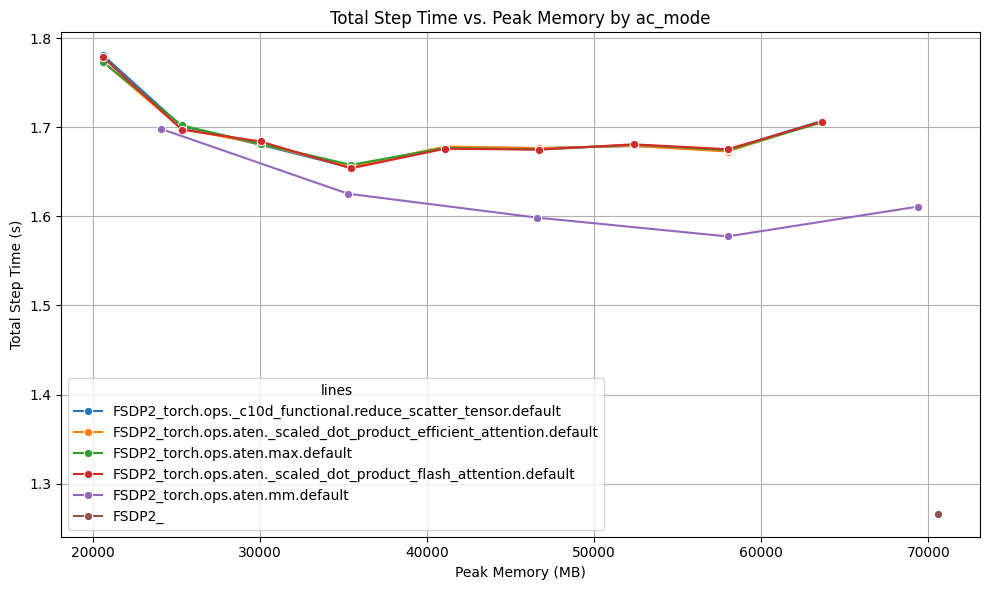

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure the data is sorted by peak_memory for proper line plotting
df_sorted = combined_df.sort_values(by="peak_memory")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_sorted,
    x="peak_memory",
    y="total_step_time",
    hue="lines",  # One line per ac_mode
    marker="o"      # Add markers for clarity
)
plt.title("Total Step Time vs. Peak Memory by ac_mode")
plt.xlabel("Peak Memory (MB)")  # Adjust label if needed
plt.ylabel("Total Step Time (s)")  # Adjust label if needed
plt.grid(True)
plt.tight_layout()
plt.show()

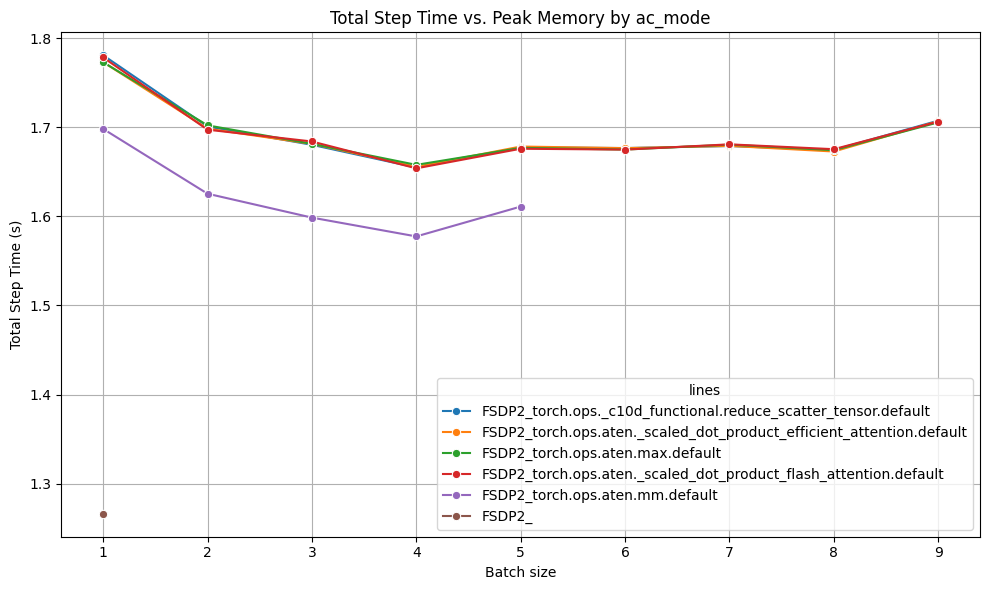

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure the data is sorted by peak_memory for proper line plotting
df_sorted = combined_df.sort_values(by="peak_memory")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_sorted,
    x="batch_size",
    y="total_step_time",
    hue="lines",  # One line per ac_mode
    marker="o"      # Add markers for clarity
)
plt.title("Total Step Time vs. Peak Memory by ac_mode")
plt.xlabel("Batch size")  # Adjust label if needed
plt.ylabel("Total Step Time (s)")  # Adjust label if needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
results_dict["compile"]

KeyError: 'compile'